In [8]:
import pandas as pd
import numpy as np
import re

import sys
sys.path.append("..")
from preprocessing.text import load_csv, normalize_path

#df = pd.read_csv("clean.csv")
df = load_csv("../data/bohacek_20211022113102.csv")
df.head()

,x,y
0,C:\Program Files (x86)\N-able Technologies\Win...,0
1,C:\Program Files (x86)\N-able Technologies\Win...,0
2,C:\Program Files (x86)\N-able Technologies\Win...,0
3,C:\Program Files (x86)\N-able Technologies\Win...,0
4,C:\Program Files (x86)\N-able Technologies\Win...,0


In [4]:
_ = df.x.iloc[5:15].apply(lambda x: print(x))

C:\USERS\CHENANHUA\DESKTOP\0604-CA\888515953.VBS
C:\Users\HISHAM\AppData\Local\Temp\is-JCEOL.tmp\online.exe
C:\Users\paulo\AppData\Local\Temp\is-V7RLA.tmp\online.exe
C:\Users\AZLAN SHAH\AppData\Local\a8122ca9-29f3-41c9-a244-845a450479d1\AD79.exe
C:\Users\danie\AppData\Local\Temp\E793.exe
C:\Users\Correos luhyi\Documents\Grace  Instrumental Piano.mp3.lnk
H:\DOWNLOAD\2021\CYBER_SECURITY_DISASTERS__HISTORY_OF_IT_DISASTERS_AND_HOW_TO_AVOID_THEM_IN_THE_FUTURE.SANET.ST.RAR
\\harvey.school\SysVol\harvey.school\Policies\{A403FFB3-79BF-4EF3-9AAA-ABE9B2010314}\User\Scripts\Logon\logonsqlnew.vbs
%Downloads%\7tt_setup.exe
C:\Users\Scott Russell\AppData\Local\Temp\stt95B5\7tt_setup.exe


# Normalize paths

Basic stuff:

1. normalize drive letters to `[drive]` and usernames to `[user]`
2. normalize environment variables 
3. network - need to transform `\\<host>\` to `[net]\`
4. address encoding - how to deal with?
    - D:\软件合集\常用软件\posetup.exe
    - F:\Ø§Ø²Ø§Ù ØªØ®ÙÙ Ø¬Ø§Ø±Ù\ÙÙØ§Ù Ø§ÙÙØ¹Ø¨Ù\GFXEngine.dll


5. Address weird stuff:

```
\\;LanmanRedirector\;Z:0000000000085b81\192.168.170.2\Main\DCIM.lnk
\\?\volume{fa067e99-0000...
*amsiprocess:c:\windows\syswow64\mshta.exe:script
```

For these - do 1. ... 3. and then catch any path w/o `[drive]` or `[net]`

In [3]:
# good reference:
# https://docs.microsoft.com/en-us/windows/deployment/usmt/usmt-recognized-environment-variables

map_variables = {
    r"%systemdrive%": r"[drive]", 
    r"%systemroot%": r"[drive]\windows",
    r"%windir%": r"[drive]\windows", 
    r"%allusersprofile%": r"[drive]\programdata",
    r"%programdata%": r"[drive]\programdata",
    r"%programfiles%": r"[drive]\program files",
    r"%programfiles(x86)%": r"[drive]\program files (x86)",
    r"%programw6432%": r"[drive]\program files",
    r"%commonprogramfiles%": r"[drive]\program files\common files",
    r"%commonprogramfiles(x86)%": r"[drive]\program files (x86)\common files",
    r"%commonprogramw6432%": r"[drive]\program files\common files",
    r"%commonfiles%": r"[drive]\program files\common files",
    r"%profiles%": r"[drive]\users",
    r"%public%": r"[drive]\users\public",
    r"%userprofile%": r"[drive]\users\[user]"
}
# more user variables
map_variables.update({
    r"%homepath%": map_variables[r"%userprofile%"],
    r"%downloads%": map_variables[r"%userprofile%"] + r"\downloads",
    r"%desktop%": map_variables[r"%userprofile%"] + r"\desktop",
    r"%favorites%": map_variables[r"%userprofile%"] + r"\favorites",
    r"%documents%": map_variables[r"%userprofile%"] + r"\documents",
    r"%mydocuments%": map_variables[r"%userprofile%"] + r"\documents", # obsolete
    r"%personal%": map_variables[r"%userprofile%"] + r"\documents", # obsolete
    r"%localsettings%": map_variables[r"%userprofile%"] + r"\documents", # obsolete
    r"%mypictures%": map_variables[r"%userprofile%"] + r"\documents\my pictures",
    r"%mymusic%": map_variables[r"%userprofile%"] + r"\documents\my music",
    r"%myvideos%": map_variables[r"%userprofile%"] + r"\documents\my videos",
    r"%localappdata%": map_variables[r"%userprofile%"] + r"\appdata\local",
    r"%appdata%": map_variables[r"%userprofile%"] + r"\appdata\roaming",
    r"%usertemp%": map_variables[r"%userprofile%"] + r"\appdata\local\temp",
    r"%temp%": map_variables[r"%userprofile%"] + r"\appdata\local\temp",
    r"%tmp%": map_variables[r"%userprofile%"] + r"\appdata\local\temp",
    r"%cache%": map_variables[r"%userprofile%"] + r"\appdata\local\microsoft\windows\temporary internet files"
})    

In [4]:
def normalize_path(path, debug=False):
    # some paths have "*raw:", "*amsiprocess:", "script started by " auxiliary strings...
    path = path.lower().replace("*raw:","").replace("*amsiprocess:","").replace("a script started by ","").strip()
    if debug:
        print(path)

    # normalize drive
    # "c:\\"" or "c:\"" will be [drive]\
    path = re.sub(r"\w:\\{1,2}", r"[drive]\\", path)
    if debug:
        print(path)

    # normalize network paths
    # need to catch "\\host\" to "[net]\"
    # [\w\d\.\-]+ comes from RFC 1035 and:
    # https://docs.microsoft.com/en-us/troubleshoot/windows-server/identity/naming-conventions-for-computer-domain-site-ou#dns-host-names
    path = re.sub(r"\\\\[\w\d\.\-]+\\", r"[net]\\", path)
    if debug:
        print(path)

    # if starts with \, and not \\ (captures not-\\ as \1 group and adds), then add [drive]
    path = re.sub(r"^\\([^\\])", r"[drive]\\\1", path)
    if debug:
        print(path)
    
    # normalize user
    default_users = ["administrator", "public", "default"]
    if "users\\" in path:
        # default user path, want to preserve them
        if not any([True if x in path else False for x in default_users]):
            path = re.sub(r"users\\[^\\]+\\", r"users\\[user]\\", path)
    if debug:
        print(path)

    # replace environment variables with paths
    for k,v in map_variables.items():
        path = path.replace(k, v)
    if debug:
        print(path)

    return path

dff = df.fullpath.apply(lambda x: normalize_path(x))

checking if there are occurences where `[user]` doesn't come after `users\`:

In [5]:
a = dff[dff.apply(lambda x:"[user]" in x)]
print("Check if correct matches are indeed correct:\n")
print(a.value_counts()[-5:],"\n")

print("Check if there are non-correct mathes:\n")
a[a.apply(lambda x: "users\\[user]" not in x)].value_counts()[-20:]

Check if correct matches are indeed correct:

[drive]\users\[user]\appdata\local\temp\rar$dia0.532\script.js                                              1
[drive]\users\[user]\downloads\hpeasystart_12_1_5139_03 (2).exe                                             1
[drive]\users\[user]\downloads\sin confirmar 34493.crdownload                                               1
[drive]\users\[user]\appdata\roaming\tencent\qqlive\episode\è±ç£é«å\19. çæ¢¦ç©ºé´.url               1
[drive]\users\[user]\appdata\roaming\tencent\qqliveappstore\episode\è±ç£é«å\33. ä½ éæä¹é.lnk    1
Name: fullpath, dtype: int64 

Check if there are non-correct mathes:



Series([], Name: fullpath, dtype: int64)

checking if only reasonable strings left where `[drive]` is not in the beginning:

In [6]:
a = dff[dff.apply(lambda x:"[drive]" in x)]
print("Check if correct matches are indeed correct:\n")
print(a.value_counts()[-5:],"\n")

print("Check if there are non-correct mathes:\n")
a[a.apply(lambda x: x[0:7] != "[drive]")].value_counts()[-20:]

Check if correct matches are indeed correct:

[drive]\program files (x86)\real\realplayer\realplay_mountpoints.exe                                                         1
[drive]\users\[user]\desktop\salud mental y bienestarpsicologico\carpeta de recursos generales de la unidad -20211009.zip    1
[drive]\users\[user]\appdata\local\temp\3vhid2pn.uxs\zen_executerunscript_11800_637666002816863581.vbs                       1
[drive]\users\[user]\onedrive\documents\mes_drivers_3.0.4.exe:script                                                         1
[drive]\users\[user]\appdata\roaming\tencent\qqliveappstore\episode\è±ç£é«å\33. ä½ éæä¹é.lnk                     1
Name: fullpath, dtype: int64 

Check if there are non-correct mathes:



\\;prlminirdr\;[drive]\mac\no name\â \-__--__---__---__--__---__--__---__--___--__---__--__---_--.{772f7fa4-513d-4a26-8a25-02f6a8919a59}    1
\\;vboxminirdr\;[drive]\vboxsrv\brenly\autorun.inf                                                                                          1
Name: fullpath, dtype: int64

same for `[net]` - no weird parsings:

In [7]:
a = dff[dff.apply(lambda x:"[net]" in x)]
print("Check if correct matches are indeed correct:\n")
print(a.value_counts()[-5:],"\n")

print("Check if there are non-correct mathes:\n")
a[a.apply(lambda x: x[0:5] != "[net]")].value_counts()[-20:]

Check if correct matches are indeed correct:

[net]\jimch_live\hrf_m02.fmx.lnk                                                                                                    1
[net]\sistemi\profis3\prog32\ivt21scrivt.exe                                                                                        1
[net]\compartido legal tributario\manual de uso marca cocha - somos progreso\manual de uso marca cocha - somos progreso copy.lnk    1
[net]\bckp\aguirrec\machado\machador\desktop\driv 3\drive.lnk                                                                       1
[net]\åæ¸¡ã\éçºãçæââå¿ç¨æè¡\paraall_2kw\paraall_2kwbase.exe                                                   1
Name: fullpath, dtype: int64 

Check if there are non-correct mathes:



Series([], Name: fullpath, dtype: int64)

check if environment variables are substituted correctly - filter all presumably env values with `%pattern%` - out of those left none acutally represents env variable:

In [8]:
dff[dff.str.contains(r"%[a-z]+%")].value_counts()

[drive]\users\administrator\appdata\local\microsoft\windows\temporary internet files\content.ie5\qngcdfdl\%cf%f2%c8õ¿%fbô¶%b3ì¿%d8%d6%c6%c8%ed%bc%fe@5552156_375084[1].exe    12
[drive]\è¿
é·ä¸è½½\%e6%8b%bc%e5%a4%9a%e5%a4%9a@2220_199.exe|>[upx]                                                                                                           5
[drive]\users\[user]\appdata\local\microsoft\windows\temporary internet files\content.ie5\74hvglnm\%d6õ¼%ab%bd%e2%c2%eb@5850403_198965[1].exe                                  1
[drive]\%programas%\keytest + serial\keyboard-test-30.exe                                                                                                                      1
Name: fullpath, dtype: int64

# Paths failed to parse

In [9]:
dff_notparsed = dff[(~dff.str.contains("[net]",regex=False)) & (~dff.str.contains("[drive]",regex=False))]
print(f"Ratio of not parsed lines: {dff_notparsed.shape[0]*100/dff.shape[0]:.4f} %")

Ratio of not parsed lines: 1.1999 %


In [10]:
_ = dff_notparsed.iloc[0:10].apply(lambda x: print(x))

mail\inbox\<subj: lanpan 18 - nmdc daily report on 10.06.2021>\dailyreport_supportcraft_rev1 10.06.2021.xlsm
surat\kotak masuk\<subj: fix nani hariyanti 0 banjarmasin kaltengsel rs6 ld1926700001>\simulasi rsc  c1 dan c2 (v9)_nani h.xlsm
surat\kotak masuk\<subj: fix nani hariyanti 0 banjarmasin kaltengsel rs6 ld1926700001>\simulasi rsc  c1 dan c2 (v9)_nani h.xlsm
edc\idp\400000\$\400000\14800
1f14\idp\140000000\758000
mail\inbox\<subj: lanpan 22 - dmr 10/06/2021>\dailyreport_supportcraft (3) 10.06.2021.xlsm
5d40\idp\140000000\$\140000000\48f200
mail\indbakke\<subj: opdatering af lpo normsy regnearket.>\lponormsy2021-2.xlsm
email\caixa de entrada\<subj: fw: resultado - one page / ranking lp / painel produtividade - mai/2021 - db: 31/05 (fechamento parcial)>\one_page_rno_v2.xlsm
email\caixa de entrada\<subj: sample approval - usinagem jj>\attachment 4.6.2_n2580-1_supplier_declaration_2019-05-07.xlsm


about 17% of those are mailing attachments having `<subj` within:

In [11]:
print(dff_notparsed.str.contains("<subj[^>]+>", regex=True).sum())
dff_notparsed.str.contains("<subj[^>]+>", regex=True).sum()/dff_notparsed.shape[0]

552


0.1727699530516432

In [12]:
_ = dff_notparsed[~dff_notparsed.str.contains("<subj[^>]+>", regex=True)].iloc[0:10].apply(lambda x: print(x))

edc\idp\400000\$\400000\14800
1f14\idp\140000000\758000
5d40\idp\140000000\$\140000000\48f200
1bb4\idp\400000\$\400000\b6a00
1974\idp\400000\$\400000\3668e0
\\;lanmanredirector\;z:00000000abd23489\gmcvo1\company\personnel\staff timesheets\mike\april2021.xlsm
8f8\idp\400000\$\400000\18a00
\\?\volume{fa067e99-0000-0000-0000-100000000000}\patchâ´s - seriales - activaciones\izotope ozone\izotope rx3\izotope_rx_3_advanced_3_02.exe
5ec\idp\400000\1b000
\\;lanmanredirector\;x:000000000001e7db\server01\x-drive\folder u x\folder u\eng0essam\eng-essam\ø§ø³øªùø§ø±ø©ø§ùøªø³ø¬ùù.one.lnk


more than half has some weird `idp` string pattern, e.g. `\idp\400000\$\400000\b6a00`:

In [13]:
print(dff_notparsed.str.contains("idp", regex=False).sum())
dff_notparsed.str.contains("idp", regex=False).sum()/dff_notparsed.shape[0]

1702


0.5327073552425665

In [14]:
_ = dff_notparsed[
        (~dff_notparsed.str.contains(r"<subj[^>]+>", regex=True)) & 
        (~dff_notparsed.str.contains("idp", regex=False))
    ].iloc[0:10].apply(lambda x: print(x))

\\;lanmanredirector\;z:00000000abd23489\gmcvo1\company\personnel\staff timesheets\mike\april2021.xlsm
\\?\volume{fa067e99-0000-0000-0000-100000000000}\patchâ´s - seriales - activaciones\izotope ozone\izotope rx3\izotope_rx_3_advanced_3_02.exe
\\;lanmanredirector\;x:000000000001e7db\server01\x-drive\folder u x\folder u\eng0essam\eng-essam\ø§ø³øªùø§ø±ø©ø§ùøªø³ø¬ùù.one.lnk
\\;lanmanredirector\;v:0000000003afa3ad\ser-dell234tt\shdoc\7_kinhdoanh\bd 21\tb lop 6\tb-lop 6_fin.xls
\\?\volume{82679eb9-ac2a-11eb-9d6f-84c5a6bee023}\kellys files\2\kellymcclure\documents\my documents\default kcssetup.exe
\\;lanmanredirector\;z:000000001ec8d3b3\servidor\datos\autorun.inf
\\?\volume{5e570b5a-ca2e-11eb-9f4e-c89cdcce3778}\setup.exe,
prace_s_cisly.zip|>prace_s_cisly.zip#2877262169|>prace s cisly\prace s cisly\bin\debug\prace s cisly.exe
odchozã­ e-mail 'yoink' od: "sebesta.marek2004@gmail.com" <sebesta.marek2004@gmail.com>, komu: "å ebesta,_marek_frantiå¡ek" <sebestam.itb20@vsps-su.cz>|>prace_s_cisly

about quarter has weird path representation like `V:0000000003afa3ad\ser-dell234tt\shdoc\7_KinhDoanh\BD 21\TB LOP 6\TB-LOP 6_Fin.xls`

In [15]:
print(dff_notparsed.str.contains(r"\w:0000").sum())
dff_notparsed.str.contains(r"\w:0000").sum()/dff_notparsed.shape[0]

780


0.24413145539906103

In [16]:
c = dff_notparsed[
        (~dff_notparsed.str.contains("<subj[^>]+>", regex=True)) & 
        (~dff_notparsed.str.contains("idp", regex=False)) &
        (~dff_notparsed.str.contains(r"\w:0000"))
    ]
print(c.shape)
_ = c.iloc[0:10].apply(lambda x: print(x))

(161,)
\\?\volume{fa067e99-0000-0000-0000-100000000000}\patchâ´s - seriales - activaciones\izotope ozone\izotope rx3\izotope_rx_3_advanced_3_02.exe
\\?\volume{82679eb9-ac2a-11eb-9d6f-84c5a6bee023}\kellys files\2\kellymcclure\documents\my documents\default kcssetup.exe
\\?\volume{5e570b5a-ca2e-11eb-9f4e-c89cdcce3778}\setup.exe,
prace_s_cisly.zip|>prace_s_cisly.zip#2877262169|>prace s cisly\prace s cisly\bin\debug\prace s cisly.exe
odchozã­ e-mail 'yoink' od: "sebesta.marek2004@gmail.com" <sebesta.marek2004@gmail.com>, komu: "å ebesta,_marek_frantiå¡ek" <sebestam.itb20@vsps-su.cz>|>prace_s_cisly.zip#2877262169|>prace s cisly\prace s cisly\bin\debug\prace s cisly.exe
ðñð¾ð´ññð°ñ ð¿ð¾ññð° 'fwd: ðð°ñðð°ð± + ððµð½ðµñð°ñð¾ññ ñ ð±ðµð»ñð¼ ññð¼ð¾ð¼' ðñ: mike sazonov <msazonov@nau-ra.ru>, ðð¾ð¼ñ: ðð½ð´ñðµð¹ ðð»ð°ñð¾ð² <andru112@mail.ru>|>2zhilin.zip#274693674|>2zhilin\generator_with_noise\generator.exe
incoming email 're: fwd: dn100 card reader issue' from: ahmed javed 

some part of files is found withing shadow copies, e.g. `\\?\Volume{614d36cf-0000-0000-0000-10f915000000}\New folder`

In [17]:
print(c.str.contains(r"volume\{[a-f0-9\-]+\}").sum())
c.str.contains(r"volume\{[a-f0-9\-]+\}").sum()/dff_notparsed.shape[0]

55


0.017214397496087636

the others left are with weird encodings:

In [18]:
d = dff_notparsed[
        (~dff_notparsed.str.contains("<subj[^>]+>", regex=True)) & 
        (~dff_notparsed.str.contains("idp", regex=False)) &
        (~dff_notparsed.str.contains(r"\w:0000")) &
        (~dff_notparsed.str.contains(r"volume\{[a-f0-9\-]+\}"))
    ]
print(d.shape)
_ = d.iloc[0:10].apply(lambda x: print(x))

(106,)
prace_s_cisly.zip|>prace_s_cisly.zip#2877262169|>prace s cisly\prace s cisly\bin\debug\prace s cisly.exe
odchozã­ e-mail 'yoink' od: "sebesta.marek2004@gmail.com" <sebesta.marek2004@gmail.com>, komu: "å ebesta,_marek_frantiå¡ek" <sebestam.itb20@vsps-su.cz>|>prace_s_cisly.zip#2877262169|>prace s cisly\prace s cisly\bin\debug\prace s cisly.exe
ðñð¾ð´ññð°ñ ð¿ð¾ññð° 'fwd: ðð°ñðð°ð± + ððµð½ðµñð°ñð¾ññ ñ ð±ðµð»ñð¼ ññð¼ð¾ð¼' ðñ: mike sazonov <msazonov@nau-ra.ru>, ðð¾ð¼ñ: ðð½ð´ñðµð¹ ðð»ð°ñð¾ð² <andru112@mail.ru>|>2zhilin.zip#274693674|>2zhilin\generator_with_noise\generator.exe
incoming email 're: fwd: dn100 card reader issue' from: ahmed javed <ajaved@innovative-pk.com>, to: anazaqat@innovative-pk.com, asamad@innovative-pk.com,ahussain03@innovative-pk.com, mmughal@innovative-pk.com,aburhan@innovative-pk.com, araza04@innovative-pk.c|>probase_c_secure_motorized_card_reader_smcr__1_0_31_2.zip#834341923|>cd1\cmd\fpmenu.exe
incoming email 'fwd: dn100 card reader is

In [6]:
#d.to_csv("not_parsed.csv", index=False)

def normalize_path(path, debug=False):
    # some paths have "*raw:", "*amsiprocess:", "script started by " auxiliary strings...
    path = path.lower().replace("*raw:","").replace("*amsiprocess:","").replace("a script started by ","").strip()
    if debug:
        print(path)

    # normalize drive
    # "c:\\"" or "c:\"" will be [drive]\
    path = re.sub(r"\w:\\{1,2}", r"[drive]\\", path)
    if debug:
        print(path)

    # normalize network paths
    # need to catch "\\host\" to "[net]\"
    # [\w\d\.\-]+ comes from RFC 1035 and:
    # https://docs.microsoft.com/en-us/troubleshoot/windows-server/identity/naming-conventions-for-computer-domain-site-ou#dns-host-names
    path = re.sub(r"\\\\[\w\d\.\-]+\\", r"[net]\\", path)
    if debug:
        print(path)

    # if starts with \, and not \\ (captures not-\\ as \1 group and adds), then add [drive]
    path = re.sub(r"^\\([^\\])", r"[drive]\\\1", path)
    if debug:
        print(path)
    
    # normalize user
    default_users = ["administrator", "public", "default"]
    if "users\\" in path:
        # default user path, want to preserve them
        if not any([True if x in path else False for x in default_users]):
            path = re.sub(r"users\\[^\\]+\\", r"users\\[user]\\", path)
    if debug:
        print(path)

    # replace environment variables with paths
    for k,v in map_variables.items():
        path = path.replace(k, v)
    if debug:
        print(path)

    return path

In [9]:
#dff = df.fullpath.apply(lambda x: normalize_path(x))
dff = df.x.apply(lambda x: normalize_path(x))

In [31]:
_ = [print(x) for x in dff.iloc[5:1500] if "[net]" in x][0:5]

[net]\sysvol\harvey.school\policies\{a403ffb3-79bf-4ef3-9aaa-abe9b2010314}\user\scripts\logon\logonsqlnew.vbs
[net]\korgun\kgshop.exe
[net]\company\personnel\staff timesheets\mike\april2021.xlsm
[net]\x-drive\folder u x\folder u\eng0essam\eng-essam\ø§ø³øªùø§ø±ø©ø§ùøªø³ø¬ùù.one.lnk
[net]\shdoc\7_kinhdoanh\bd 21\tb lop 6\tb-lop 6_fin.xls
[net]\01-quanlydonhang\foster-diep-2112.rar
[net]\netlogon\ci-sign\ci-sign-net.vbs


playing with `utf-8` encoding, how to represent strings as list of byte integers:

In [338]:
ts = d.apply(lambda x: x.encode("utf-8", "ignore")).iloc[19]
ts

b'\\\\;ncfsd\\cscidc\\sys_data\\thuno\\taichinh\\so phu ngan hang\\so phu ngan hang\\bidv - tk 14156\\2021\\t6-2021\\8 6 2021.xls'

In [341]:
print(ts[0:4])
list(ts[0:4])

b'\\\\;n'


[92, 92, 59, 110]

In [11]:
from collections import Counter
utf8 = Counter()
for x in dff.iloc[0:10]:
    utf8 += Counter(list(x.encode("utf-8", "ignore")))


In [12]:
utf8.most_common(3)

[(101, 66), (92, 66), (115, 59)]

NOTE: convert back and forth:

In [13]:
def byte_int_to_str(byte_int):
    # big or little doesn't matter for 1 byte
    return byte_int.to_bytes(1, "big") 

print(byte_int_to_str(101))
print(byte_int_to_str(92))
print(byte_int_to_str(115))

b'e'
b'\\'
b's'


In [14]:
utf8 = Counter()
for x in dff:
    utf8 += Counter(list(x.encode("utf-8", "ignore")))

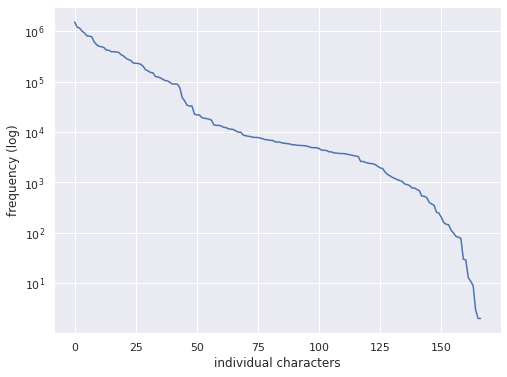

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

graph = utf8.most_common()
plt.figure(figsize=(8,6))
plt.plot([x[1] for x in graph])
plt.ylabel("frequency (log)")
plt.xlabel("individual characters")
plt.yscale("log")

We see nice drop of frequency around 150

`https://arxiv.org/abs/1905.06987` as well says:

```
In our work, we consider the entire unicode (UTF-8) character set, 
but limit our vocabulary to 150 most frequently occurring unicode characters,
determined by their frequency counts in our data (See Figure 2).
```

In [400]:
most_150_common_bytes = [x[0] for x in utf8.most_common(150)]

How long are filepaths generally?

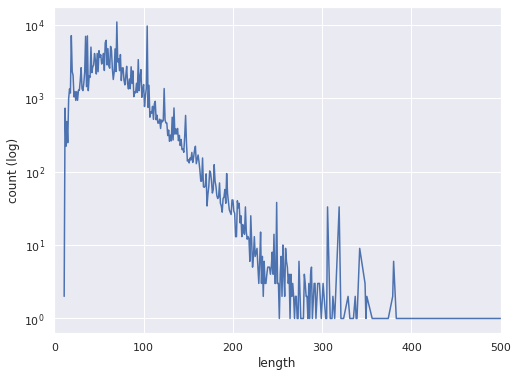

In [33]:
lengths = dff.apply(lambda x: len(x)).value_counts().sort_index()
plt.figure(figsize=(8,6))
plt.plot(lengths.index, lengths.values)
plt.xlim([0,500])
plt.yscale("log")
plt.ylabel("count (log)")
_ = plt.xlabel("length")

In [51]:
def get_perc(dff,l):
    print(f"Percentage of paths under {l} is: {(dff.apply(lambda x: len(x)) < l).sum()*100/dff.shape[0]:.2f}")
get_perc(dff, 150)
get_perc(dff, 100)
get_perc(dff, 75)
get_perc(dff, 50)
get_perc(dff, 25)

Percentage of paths under 150 is: 98.04
Percentage of paths under 100 is: 84.53
Percentage of paths under 75 is: 67.60
Percentage of paths under 50 is: 31.64
Percentage of paths under 25 is: 7.43


in paper they say that they have similar stats, with 300 a good lim to cut paths, however, if they trim paths at 100, it results in similar accuracy, but much faster performace

just in case - which paths are longer than 300 symbols?  

mostly repeating patterns:  
     - ok to trim beginning and use last 150 chars? ...  
     - or better to preserve first 50 chars + last 100 chars ? 

In [431]:
print(dff.apply(lambda x: len(x) > 300).sum())
_ = dff[dff.apply(lambda x: len(x) > 300)].iloc[-10:].apply(lambda x: print(x))

126
[drive]\ð¢ð²ð¾ð¹_ððµð±ðµñð½ñð¹_ðð¾ðºñð¾ð²ð¸ñðµð»ñ ðð½ñð¾ñð¼ð°ñð¸ñ\ð ð¿ñð°ð²ð¾ñð»ð°ð²ð¸ð¸ ðð\ðñð°ð²ð¾ñð»ð°ð²ð¸ðµ ð¼ð½ð¾ð³ð¾ ñð¾ ññð°ñð¾ð³ð¾ ðºð¾ð¼ð¿ð°\! ! !  html ð¸ dpd\ðñðµñññð¿ð½ð¾ññð¸ ððð¢ - ð£ñðµð½ñðµ ð½ð°ð·ð²ð°ð»ð¸ ñð¾ñð½ññ ð´ð°ññ ñð¼ðµññð¸ ðð¸ñññð° ð¥ñð¸ññð°.mht
[drive]\ð¢ð²ð¾ð¹_ððµð±ðµñð½ñð¹_ðð¾ðºñð¾ð²ð¸ñðµð»ñ ðð½ñð¾ñð¼ð°ñð¸ñ\ð ð¿ñð°ð²ð¾ñð»ð°ð²ð¸ð¸ ðð\ðñð°ð²ð¾ñð»ð°ð²ð¸ðµ ð¼ð½ð¾ð³ð¾ ñð¾ ññð°ñð¾ð³ð¾ ðºð¾ð¼ð¿ð°\! ! !  html ð¸ dpd\ðñðµñññð¿ð½ð¾ññð¸ ððð¢ - ð£ñðµð½ñðµ ð½ð°ð·ð²ð°ð»ð¸ ñð¾ñð½ññ ð´ð°ññ ñð¼ðµññð¸ ðð¸ñññð° ð¥ñð¸ññð°.mht
[drive]\ð¢ð²ð¾ð¹_ððµð±ðµñð½ñð¹_ðð¾ðºñð¾ð²ð¸ñðµð»ñ ðð½ñð¾ñð¼ð°ñð¸ñ\ð ð¿ñð°ð²ð¾ñð»ð°ð²ð¸ð¸ ðð\ðñð°ð²ð¾ñð»ð°ð²ð¸ðµ ð¼ð½ð¾ð³ð¾ ñð¾ ññð°ñð¾ð³ð¾ ðºð¾ð¼ð¿ð°\! ! !  html ð¸ dpd\ðñðµñññð¿ð½ð¾ññð¸ ððð¢ - ð£ñðµð½ñðµ ð½ð°ð·ð²ð°ð»ð¸ ñð¾ñð½ññ ð´ð°ññ ñð¼ðµññð¸ ðð¸ñññð° ð¥ñð¸ññð°.mht
[drive]\ð¢ð²ð¾ð¹_ððµð±ðµñð½ñð¹_ð


```
We also add a single ‘other‘ character that represents all other
UTF-8 characters not in the top 150, and a special null character
to represent shorter strings (padded ends).

Final size 152.
```

TODO:
1. `list(string.encode("utf-8", "ignore))`
2. if not in most common 150 - replace with "other"
3. if shorter than 100 (in paper), pad with "null"